In [1]:
#Failed to build scikit-image lap
#!pip install -r sort_requirements.txt

  Using cached scikit-image-0.17.2.tar.gz (29.8 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached lap-0.4.0.tar.gz (1.5 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for scikit-image
  Running setup.py clean for lap
Failed to build scikit-image lap


  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [643 lines of output]
  C:\Users\Asus\AppData\Local\Temp\pip-install-6wif4e75\scikit-image_2c923c90b6a54c88ac7dbb0f8bed9400\setup.py:159: DeprecationWarning:
  
    `numpy.distutils` is deprecated since NumPy 1.23.0, as a result
    of the deprecation of `distutils` itself. It will be removed for
    Python >= 3.12. For older Python versions it will remain present.
    It is recommended to use `setuptools < 60.0` for those Python versions.
    For more details, see:
      https://numpy.org/devdocs/reference/distutils_status_migration.html
  
  
    from numpy.distutils.core import setup
  D:\anaconda\Lib\site-packages\setuptools\config\setupcfg.py:293: _DeprecatedConfig: Deprecated config in `setup.cfg`
  !!
  
          ********************************************************************************
          The license_file parameter is deprecated, use license_files i

In [2]:
#!pip install -r utils_requirements.txt

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import torch
import cv2
import matplotlib.pyplot as plt
import os

from utils import write_metrics_to_df, write_time_to_df, replace_cuda_with_cpu, make_all_numpy,\
 video_annot_txt_to_dataframe, motMetricsEnhancedCalculator, convert_array, usingPIL

In [4]:
#path to sequeuence on local : D:\Drone_object_tracking\VisDrone2019-MOT-val\sequences\uav0000086_00000_v
#path to sequeuence on colab /content/drive/MyDrive/VisDrone2019-MOT-val/sequences/uav0000086_00000_v
from os import walk
#uav0000086_00000_v
#uav0000268_05773_v
video_name = 'uav0000086_00000_v'
dir_path_source_sequences = 'D:\\Drone_object_tracking\\VisDrone2019-MOT-val\\sequences'
dir_path_source_annotations = 'D:\\Drone_object_tracking\\VisDrone2019-MOT-val\\annotations'
dir_path = 'D:\\Drone_object_tracking\\VisDrone2019-MOT-val\\sequences'+video_name
annot_path = 'D:\\Drone_object_tracking\\VisDrone2019-MOT-val\\annotations'+video_name+'.txt'


#filenames = next(walk(dir_path), (None, None, []))[2]  # [] if no file

In [20]:
#%matplotlib inline
#import matplotlib.pyplot as plt
import datetime
import cv2
from time import time
def make_predictions(model=None, tracker=None, dir_path_sequences=None, img_size=None):
    '''
    input:
    model - model for predictions. MUST return predictions in formst like YOLOv8
    tracker - MOT technic. SORT or DeepSORT
    dir_path_sequences - string path to video sequence('D:\\Drone_object_tracking\\VisDrone2019-MOT-val\\sequences\\uav0000268_05773_v') as example
    img_size - image size for YOLO inference

    return:
    preds - dataframe of predictions in MOT16 format
    str_res - string with description of time characteristics of alghorithm
    times - dataframe of time wasted for different parts of function
    '''
    #print(next(walk(dir_path_sequences)))
    #print(dir_path_sequences+'/'+next(walk(dir_path_sequences)))
    height, width = cv2.imread(dir_path_sequences+'/'+next(walk(dir_path_sequences))[2][0]).shape[:2]

    fourcc = cv2.VideoWriter_fourcc('M', 'J', 'P', 'G')

    try:
        os.remove("video.avi")
    except: pass

    video = cv2.VideoWriter('video.avi', fourcc, 20, (width, height))

    mot_tracker = tracker

    #acc = mm.MOTAccumulator(auto_id=True)
    #annots = video_annot_txt_to_dataframe('D:\\Drone_object_tracking\\VisDrone2019-MOT-val\\annotations\\uav0000086_00000_v.txt')
    columns=['frame_number','obj_id','left_top_x','left_top_y','width','height','confidence', 'category','truncation',
                'occlusion']

    preds = pd.DataFrame(columns=columns)
    #print(len(filenames))

    avg_yolo_time = 0.
    avg_predictor_time = 0.
    avg_frame_time_arr= []
    avg_yolo_time_arr= []
    avg_predictor_time = []
    avg_resizing_time = []
    avg_drawing_time = []
    avg_reading_time = []

    filenames = sorted(next(walk(dir_path_sequences), (None, None, []))[2])#BUG may appear
    #print(filenames)
    #i = 0
    for idx, img_relative_path in enumerate(filenames):

        time_before_fps  = time()
        path = dir_path_sequences+'/'+img_relative_path

        time_before_reading = time()
        #img = cv2.imread(path)    #Using this, time after - before is NEARLY equal for 928px, for 640 still different(at the begging of small inference time is 20 ms)
        img = usingPIL(path)
        time_after_reading = time()
        avg_reading_time.append((time_after_reading-time_before_reading)*1000)

        time_before_resizing = time()

        time_after_resizing = time()
        avg_resizing_time.append((time_after_resizing-time_before_resizing)*1000)

        time_before_YOLO = time()
        prediction = model(img, verbose=False,imgsz=img_size)
        time_after_YOLO = time()
        boxes =  prediction[0].boxes.xyxy.type(torch.IntTensor).to('cuda')
        scores = prediction[0].boxes.conf
        classes = prediction[0].boxes.cls.type(torch.IntTensor)
        scores = torch.unsqueeze(scores, 1)

        torch_detections = torch.cat((boxes,scores), dim=1)
        torch_detections_cpu = replace_cuda_with_cpu(torch_detections)
        numpy_detections = make_all_numpy(torch_detections_cpu)

        time_before_updating_tracker = time()
        if type(mot_tracker) == DeepSort:
          numpy_detections = np.concatenate((numpy_detections,np.expand_dims(classes.cpu().numpy(),axis=1) ),
                                            axis=1)
          #print('a')
          result_tracker = mot_tracker.update_tracks(convert_array(numpy_detections), frame=img) # WARNING here
          #print('b')
          results = []

          for res in result_tracker:
            arr = res.to_tlwh().tolist()
            arr.append(res.track_id)
            results.append(arr)



        else:
          result_tracker = mot_tracker.update(numpy_detections)
          results = result_tracker

        time_after_updating_tracker = time()

        time_before_drawing_predictions = time()

        for res in results:

            x1, y1, x2, y2, obj_id = [int(a) for a  in res]


            cv2.rectangle(img, (x1, y1),(x2, y2), color=(255,0,0), thickness=2)
            cv2.putText(img,str(obj_id), (x1, y1), cv2.FONT_HERSHEY_SIMPLEX,1, (0,255,0), thickness=2 )

            single_pred = [idx+1,obj_id,x1, y1, x2-x1, y2-y1,1,1,1,1]
            s = pd.Series(single_pred, index=columns)
            preds = pd.concat([s.to_frame().T, preds], ignore_index=True, axis=0)

        time_after_drawing_predictions = time()
        video.write(img)  #about 30 seconds for uav0000086_00000_v
        time_after_fps = time()

        avg_drawing_time.append((time_after_drawing_predictions-time_before_drawing_predictions)*1000)
        avg_frame_time_arr.append((time_after_fps-time_before_fps)*1000)
        avg_yolo_time_arr.append(time_after_YOLO - time_before_YOLO)
        avg_predictor_time.append(time_after_updating_tracker - time_before_updating_tracker)
        #img = image_resize(img, width=width)



    str_res = ''
    str_res+=dir_path+'\n'
    str_res+= f'Resized to {img_size}\n'
    str_res+=f'image width:{width}, image height:{height}\n'
    str_res+=f'Image reading time ms: {sum(avg_reading_time)/len(avg_reading_time)}\n'
    str_res+=f'Image resizing time ms: {sum(avg_resizing_time)/len(avg_resizing_time)}\n'
    str_res+=f'Avarage Yolo time ms:{sum(avg_yolo_time_arr)/len(avg_yolo_time_arr) * 1000}\n'
    str_res+=f'Avarage predictor time ms:{sum(avg_predictor_time)/len(avg_predictor_time) * 1000}\n'
    str_res+=f'Drawing predictions time ms: {sum(avg_drawing_time)/len(avg_drawing_time)}\n'

    #print(len(preds))
    times = write_time_to_df(video_name=dir_path_sequences,
                             resized_to=img_size,
                             source_width=width,
                             source_height=height,
                             avg_reading_time=sum(avg_reading_time)/len(avg_reading_time),
                             avg_resizing_time=sum(avg_resizing_time)/len(avg_resizing_time),
                             avg_yolo_time=sum(avg_yolo_time_arr)/len(avg_yolo_time_arr) * 1000,
                             avg_predictor_time=sum(avg_predictor_time)/len(avg_predictor_time) * 1000,
                             avg_drawing_time=sum(avg_drawing_time)/len(avg_drawing_time),
                             avg_fps_time=sum(avg_frame_time_arr)/len(avg_frame_time_arr))

    return preds, str_res, times



In [21]:
def proccess_single_video(model=None, tracker=None, dir_path_source_sequences=None, dir_path_source_annotations=None,
                          video_name=None, img_sz=None):
  """
  proccesses one video: find time and accuracy metrics on given video

  input:
  dir_path_source_sequences - '/content/drive/MyDrive/VisDrone2019-MOT-val/sequences/'
  dir_path_source_annotations - '/content/drive/MyDrive/VisDrone2019-MOT-val/annotations/'
  video_name - name of video for both annots and sequences

  return:
  time_df - time results dataframe
  metrics_df - metrics results dataframe
  """
  print(video_name,img_sz)
  preds, res_str, time_df = make_predictions(model,tracker, dir_path_source_sequences+'/'+video_name,img_sz)

  annots = video_annot_txt_to_dataframe(f'{dir_path_source_annotations}/{video_name}.txt')

  MOT, metrics_df = motMetricsEnhancedCalculator(annots.to_numpy(), preds.to_numpy() )

  return time_df, metrics_df

In [22]:
def proccess_all_videos():
  time_columns=['video_name','resized_to', 'source_width','source_height','avg_reading_time','avg_resizing_time',
              'avg_yolo_time','avg_predictor_time','avg_drawing_time']
  times_dataframe = pd.DataFrame(columns=time_columns)


  metric_columns = ['num_frames', 'idf1', 'idp', 'idr', 'recall', 'precision', 'num_objects',  'mostly_tracked',
                    'partially_tracked', 'mostly_lost', 'num_false_positives', 'num_misses', 'num_switches',
                    'num_fragmentations', 'mota', 'motp']
  metrics_dataframe = pd.DataFrame(columns=metric_columns)

  with open('results.txt', 'w') as f:
      for video in  os.listdir(dir_path_source_sequences):
          for s in [640,928]:

              print(video)
              print(s)

              times_df, metrics_df = proccess_single_video(dir_path_source_sequences,dir_path_source_annotations,video, s)

              times_dataframe = pd.concat([times_df, times_dataframe], ignore_index=True, axis=0)
              metrics_dataframe = pd.concat([metrics_dataframe, metrics_df], ignore_index=True, axis=0)

              return times_dataframe, metrics_dataframe


In [23]:

#!pip install ultralytics
#https://github.com/levan92/deep_sort_realtime/blob/master/deep_sort_realtime/embedder/embedder_pytorch.py
#!pip install deep-sort-realtime

In [24]:
from sort import Sort
#from deepsort.tracker import DeepSortTracker
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort

In [25]:
# Load a pretrained model
# Weights from https://huggingface.co/ENOT-AutoDL/yolov8s_visdrone/tree/main/enot_neural_architecture_selection_x3/weights


model = YOLO("YOLOv8s(x3).pt")

model.to('cuda');
tracker = DeepSort(max_age=5,
                   nms_max_overlap=0.7)

In [26]:
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [27]:
time_df, metrics_df = proccess_single_video(model=model,
                                            tracker=tracker,
                                            dir_path_source_sequences=dir_path_source_sequences,
                                            dir_path_source_annotations=dir_path_source_annotations,
                                            video_name=video_name,
                                            img_sz=640)

uav0000086_00000_v 640


In [28]:
time_df['clear_fps'] = time_df['avg_reading_time'] + time_df['avg_yolo_time'] + time_df['avg_predictor_time']

In [29]:
result = pd.concat((time_df, metrics_df), axis=1, ignore_index=False)
result.to_csv('YOLOv8_s(x3)+DeepSORT.csv', sep=';', index = False)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

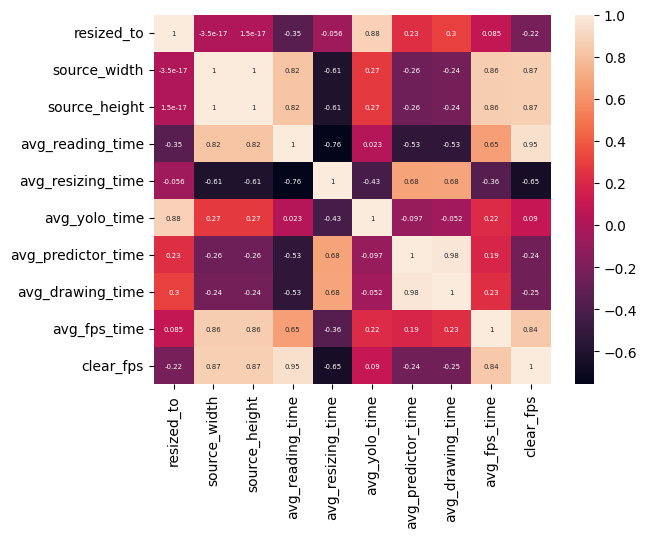

In [ ]:
sns.heatmap(times_dataframe.drop(['video_name'], axis=1).astype(np.float64).corr(), annot=True, annot_kws={"size": 5})
plt.show()

In [ ]:
result.sort_values('clear_fps')\
 [['resized_to',	'source_width',	'source_height',	'avg_reading_time','avg_yolo_time','avg_predictor_time','clear_fps']]

,resized_to,source_width,source_height,avg_reading_time,avg_yolo_time,avg_predictor_time,clear_fps
11,640,1344,756,16.377552,15.495502,14.943862,46.816915
10,928,1344,756,13.512291,18.842658,16.97352,49.328468
6,928,1344,756,15.06494,19.428051,19.575575,54.068567
4,928,1904,1071,20.995406,20.796428,14.535476,56.32731
2,928,1904,1071,20.882124,19.834802,16.33095,57.047876
7,640,1344,756,33.729109,17.155978,15.469745,66.354833
13,640,2720,1530,35.697858,15.064774,15.970098,66.732731
5,640,1904,1071,40.430645,16.634209,11.215157,68.280011
3,640,1904,1071,41.692787,16.488793,14.595588,72.777168
12,928,2720,1530,33.069185,20.300085,24.987144,78.356414
